In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#for changing replicas
current_complex = '1JPS'
replica_no = str(1)

current_replica = 'replica' + replica_no
input_directory = './'+ current_complex + '/' + current_replica
input_files = input_directory + '/rep' + replica_no + '-interfacea' #takes input files (.interfacea)
out_files = "." + '/merged_outputs' #currently created manually in gdrive

files_list = os.listdir(input_files)
print(files_list)

['complex_md-fit_1.pdb.interfacea', 'complex_md-fit_123.pdb.interfacea', 'complex_md-fit_136.pdb.interfacea', 'complex_md-fit_147.pdb.interfacea', 'complex_md-fit_152.pdb.interfacea', 'complex_md-fit_26.pdb.interfacea', 'complex_md-fit_33.pdb.interfacea', 'complex_md-fit_42.pdb.interfacea', 'complex_md-fit_57.pdb.interfacea', 'complex_md-fit_9.pdb.interfacea', 'complex_md-fit_131.pdb.interfacea', 'complex_md-fit_124.pdb.interfacea', 'complex_md-fit_58.pdb.interfacea', 'complex_md-fit_6.pdb.interfacea', 'complex_md-fit_155.pdb.interfacea', 'complex_md-fit_140.pdb.interfacea', 'complex_md-fit_29.pdb.interfacea', 'complex_md-fit_34.pdb.interfacea', 'complex_md-fit_21.pdb.interfacea', 'complex_md-fit_148.pdb.interfacea', 'complex_md-fit_50.pdb.interfacea', 'complex_md-fit_45.pdb.interfacea', 'complex_md-fit_139.pdb.interfacea', 'complex_md-fit_149.pdb.interfacea', 'complex_md-fit_20.pdb.interfacea', 'complex_md-fit_35.pdb.interfacea', 'complex_md-fit_138.pdb.interfacea', 'complex_md-fit_44

In [3]:
# Ensure the output directory exists
os.makedirs(out_files, exist_ok=True)

for i in range(0, len(files_list)):
    if files_list[i].endswith(".interfacea"):
        # Read the input file
        df = pd.read_table(input_files + "/" + files_list[i], delim_whitespace=True)
        
        # Drop the last two columns
        df_colDrop = df.drop(columns=[df.columns[-2], df.columns[-1]])
        
        # Remove duplicate rows
        df_dropped = df_colDrop.drop_duplicates()
        
        # Filter and write to respective files for hydrophobics, hbonds, and ionics
        filtered_df_hydrophobic = df_dropped[df_dropped["itype"] == 'hydrophobic']
        with open(out_files + "/" + "hydrophobics", 'a') as file:
            filtered_df_hydrophobic.to_csv(file, header=False, index=False, sep="\t")

        filtered_df_hbond = df_dropped[df_dropped["itype"] == 'hbond']
        with open(out_files + "/" + "hbonds", 'a') as file:
            filtered_df_hbond.to_csv(file, header=False, index=False, sep="\t")

        filtered_df_ionic = df_dropped[df_dropped["itype"] == 'ionic']
        with open(out_files + "/" + "ionics", 'a') as file:
            filtered_df_ionic.to_csv(file, header=False, index=False, sep="\t")


In [8]:
def frequency_graph(interact_type): #valid interact types: hydrophobic, ionics, hbonds

    b=pd.read_csv(out_files+"/"+ interact_type, sep="\t", header=None) #
    b.columns = ["itype", "chain_a", "chain_b", "resname_a", "resname_b", "resid_a", "resid_b" ]
    b["resname_a"] = b["resname_a"].astype(str) + b["chain_a"].astype(str) + b["resid_a"].astype(str)
    b["resname_b"] = b["resname_b"].astype(str) + b["chain_b"].astype(str) + b["resid_b"].astype(str)


    #Intermonomer interactions
    b_inter = b.loc[((b["chain_a"] == "A") & (b["chain_b"] == "C")) | ((b["chain_a"] == "C") & (b["chain_b"] == "A")) ]

    #Pairwise interactions
    b_inter['pairwise'] = b_inter['resname_a'].str.cat(b_inter['resname_b'],sep="-")

    #interaction freqs
    b_inter['aa_freq'] = b_inter.groupby('resname_a')['resname_a'].transform('count')
    b_inter['nuc_freq'] = b_inter.groupby('resname_b')['resname_b'].transform('count')
    b_inter['all_freq'] = b_inter.groupby('itype')['itype'].transform('count')
    b_inter['pair_freq'] = b_inter.groupby('pairwise')['pairwise'].transform('count') / 4 #over 4 reps
    b_inter['pair'] = b_inter.groupby('pairwise')['pairwise'].transform('count')
    b_inter['freq'] = (b_inter['pair'] / 200) * 100

    #print(b_inter)

    b_inter_sorted=b_inter.sort_values(('freq') , ascending=False)

    #setting colors
    colors = "Blues_r";
    if interact_type == "ionics":
        colors = "Reds_r"

    if interact_type == "hbonds":
        colors = "Greens_r"

    plt.figure(figsize=(13,8))
    ax = sns.barplot(x="pairwise", y="freq", palette=colors, data=b_inter_sorted)
    plt.xticks(rotation='vertical')


    plt.xticks(fontsize=13, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.ylim(ymax = 100)
    plt.xlabel('Interactions',  fontweight='bold')
    plt.ylabel('Percentage of ' + interact_type[:-1] + ' interactions', fontweight='bold')
    plt.title('General '  + interact_type[:-1] + ' interaction profile of 1JPS for Chain A-C Interaction',  fontweight='bold')


    plt.savefig("./" +"/general-" + interact_type +"-pairwise.png",dpi=300, bbox_inches="tight", format="png")

    return b_inter


## Let's visualize our interactions

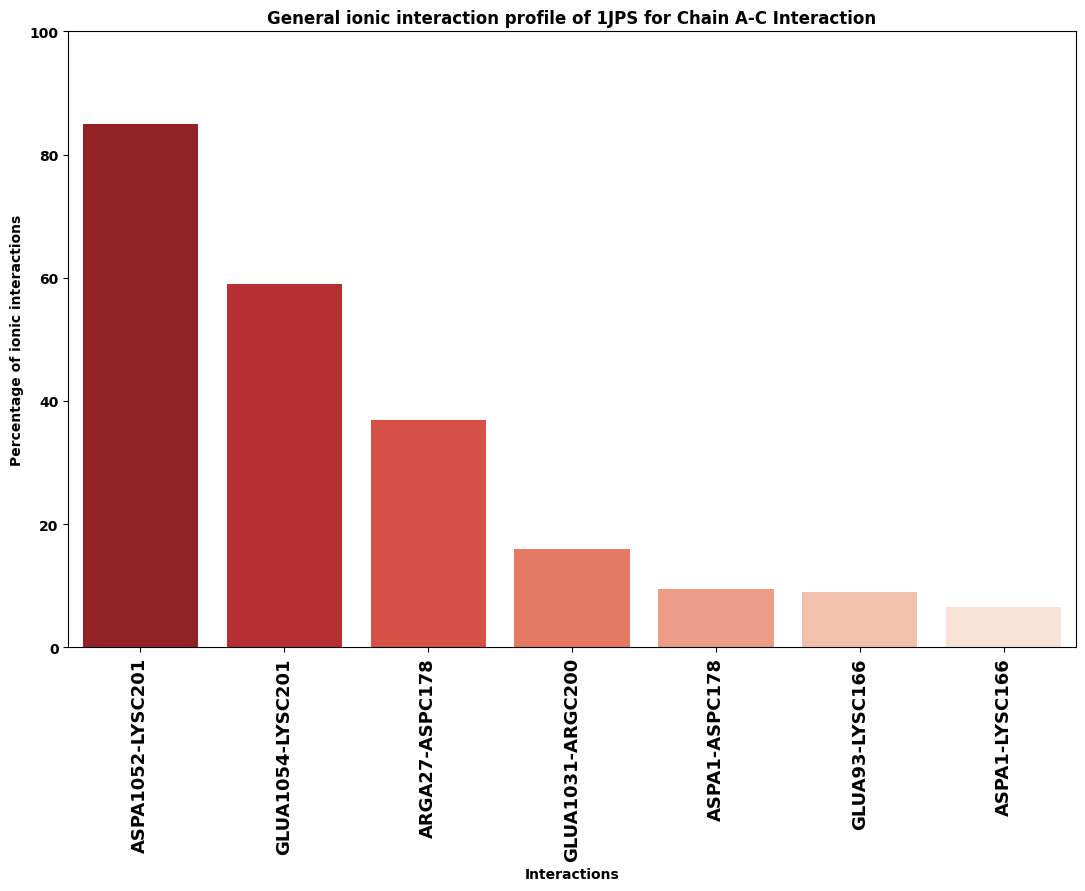

In [9]:
b_inter = frequency_graph("ionics")

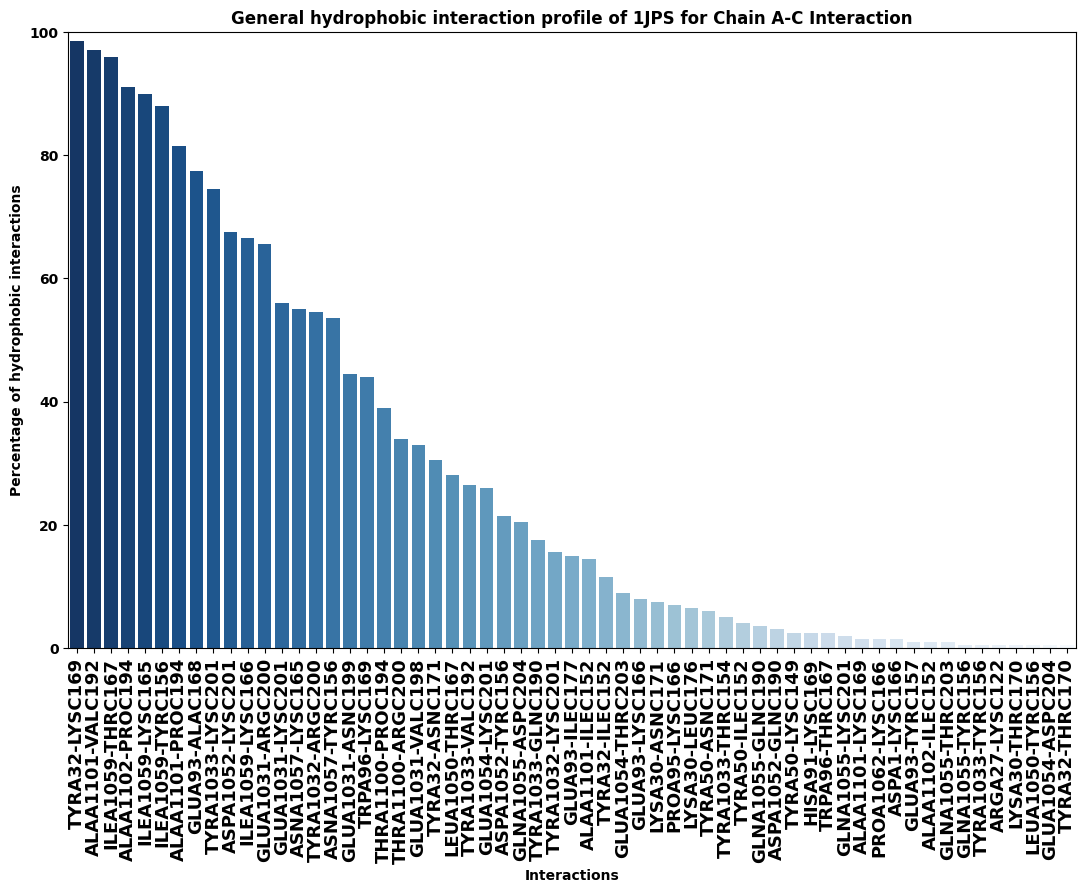

In [10]:
b_inter = frequency_graph("hydrophobics")

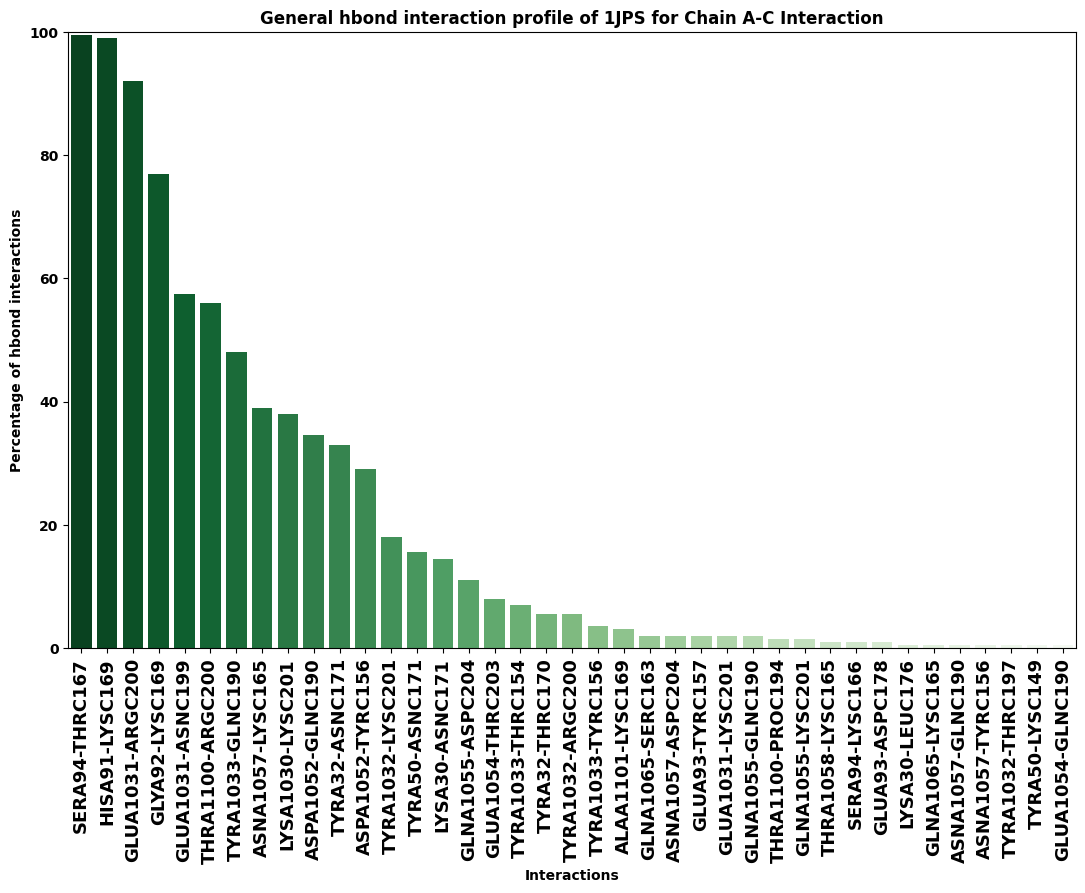

In [11]:
b_inter = frequency_graph("hbonds")